<a href="https://colab.research.google.com/github/valeriad0l/Voice-Based-Sentiment-Analysis/blob/main/RAVDESS%2BTESS%2BCREMA_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install librosa pydub matplotlib seaborn scikit-learn --quiet

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import random
import pickle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"valeriadol","key":"06c3594a1bc5107152bdd8412a839fc2"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download datasets from Kaggle
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!kaggle datasets download -d ejlok1/cremad

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
toronto-emotional-speech-set-tess.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
ravdess-emotional-speech-audio.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
cremad.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile

with zipfile.ZipFile("ravdess-emotional-speech-audio.zip", 'r') as zip_ref:
    zip_ref.extractall("ravdess_data")

with zipfile.ZipFile("toronto-emotional-speech-set-tess.zip", 'r') as zip_ref:
    zip_ref.extractall("tess_data")

with zipfile.ZipFile("cremad.zip", 'r') as zip_ref:
    zip_ref.extractall("crema_data")

In [8]:
# Define paths
ravdess_path = "ravdess_data"
tess_path = "tess_data"
crema_path = "crema_data"

In [20]:
# Mel spectrogram extractor with optional augmentation
def audio_to_mel_spectrogram(file_path, n_mels=128, max_len=128, augment=False):
    y, sr = librosa.load(file_path, sr=None)

    if augment:
        if random.random() < 0.5:
            steps = random.choice([-3, -2, -1, 1, 2, 3])
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)
        if random.random() < 0.5:
            rate = random.uniform(0.8, 1.2)
            y = librosa.effects.time_stretch(y, rate=rate)
        if random.random() < 0.3:
            noise_amp = 0.005 * np.random.uniform() * np.amax(y)
            y = y + noise_amp * np.random.normal(size=y.shape)

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]
    return mel_db

In [10]:
# RAVDESS
emotion_map_ravdess = {'03': 'happy', '04': 'sad', '05': 'angry'}
ravdess_filepaths, ravdess_emotions = [], []
for root, dirs, files in os.walk(ravdess_path):
    for file in files:
        if file.endswith(".wav"):
            parts = file.split('-')
            emotion_code = parts[2]
            if emotion_code in emotion_map_ravdess:
                ravdess_filepaths.append(os.path.join(root, file))
                ravdess_emotions.append(emotion_map_ravdess[emotion_code])
df_ravdess = pd.DataFrame({'file': ravdess_filepaths, 'label': ravdess_emotions})

In [11]:
# TESS
target_emotions_tess = ['happy', 'sad', 'angry']
tess_filepaths, tess_emotions = [], []
for root, dirs, files in os.walk(tess_path):
    for file in files:
        if file.endswith(".wav"):
            for emotion in target_emotions_tess:
                if emotion in root.lower():
                    tess_filepaths.append(os.path.join(root, file))
                    tess_emotions.append(emotion)
                    break
df_tess = pd.DataFrame({'file': tess_filepaths, 'label': tess_emotions})

In [12]:
# CREMA-D
crema_filepaths, crema_emotions = [], []
for root, dirs, files in os.walk(os.path.join(crema_path, "AudioWAV")):
    for file in files:
        if file.endswith(".wav"):
            parts = file.split('_')
            if len(parts) > 2:
                emotion_code = parts[2]
                if emotion_code == 'HAP':
                    crema_emotions.append('happy')
                elif emotion_code == 'SAD':
                    crema_emotions.append('sad')
                elif emotion_code == 'ANG':
                    crema_emotions.append('angry')
                else:
                    continue
                crema_filepaths.append(os.path.join(root, file))
df_crema = pd.DataFrame({'file': crema_filepaths, 'label': crema_emotions})

In [13]:
# Combine RAVDESS + TESS + CREMA-D
df_combined = pd.concat([df_ravdess, df_tess, df_crema], ignore_index=True)
print("Combined dataset size:", len(df_combined))
print(df_combined['label'].value_counts())
df_combined.head()

Combined dataset size: 7365
label
happy    2455
angry    2455
sad      2455
Name: count, dtype: int64


,file,label
0,ravdess_data/Actor_13/03-01-03-02-02-01-13.wav,happy
1,ravdess_data/Actor_13/03-01-05-01-02-02-13.wav,angry
2,ravdess_data/Actor_13/03-01-04-01-01-01-13.wav,sad
3,ravdess_data/Actor_13/03-01-03-02-01-01-13.wav,happy
4,ravdess_data/Actor_13/03-01-05-02-02-01-13.wav,angry


In [15]:
# Feature extraction with augmentation
X = []
y = []
label_to_index = {'happy': 0, 'sad': 1, 'angry': 2}

for i, row in tqdm(df_combined.iterrows(), total=len(df_combined)):
    mel = audio_to_mel_spectrogram(row['file'], augment=True)
    X.append(mel)
    y.append(label_to_index[row['label']])

X = np.array(X)[..., np.newaxis]
y = to_categorical(np.array(y), num_classes=3)

# Save preprocessed data to disk
np.save("X_data.npy", X)
np.save("y_data.npy", y)

# Download the saved files
from google.colab import files
files.download("X_data.npy")
files.download("y_data.npy")

100%|██████████| 7365/7365 [07:48<00:00, 15.73it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# OPTIONAL: Load preprocessed data (skip feature extraction)
from google.colab import files
uploaded = files.upload()  # Upload X_data.npy and y_data.npy

import numpy as np

X = np.load("X_data.npy")
y = np.load("y_data.npy")

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [21]:
# Class weights
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
class_weights = dict(enumerate(class_weights))

# Model definition
model = keras.Sequential([
    layers.Input(shape=(128, 128, 1)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            verbose=1
        )
    ]
)

model.save("ravdess_tess_crema_model.keras")

# Downloaded locally
from google.colab import files
files.download("ravdess_tess_crema_model.keras")


Epoch 1/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.4961 - loss: 2.8895 - val_accuracy: 0.6219 - val_loss: 1.3568 - learning_rate: 0.0010
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.5956 - loss: 0.7785 - val_accuracy: 0.4711 - val_loss: 3.2824 - learning_rate: 0.0010
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6378 - loss: 0.7543
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
185/185 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.6378 - loss: 0.7542 - val_accuracy: 0.5913 - val_loss: 2.1030 - learning_rate: 0.0010
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.6965 - loss: 0.6509 - val_accuracy: 0.6415 - val_loss: 1.0386 - learning_rate: 5.0000e-04
Epoch 5/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.6895 - loss: 0.6237 - val_accuracy: 0.6083 - val_loss: 1.8922 - learning_rate: 5.0000e-04
Epoch 6/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7143 - loss:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your saved model (.keras file)

from tensorflow import keras
model = keras.models.load_model("ravdess_tess_crema_model.keras")

In [ ]:
# Reload the training/validation loss/accuracy curves
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Download it
files.download("training_history.pkl")

In [ ]:
uploaded = files.upload()
with open("training_history.pkl", "rb") as f:
    history_data = pickle.load(f)

47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 340ms/step
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       491
           1       0.64      0.99      0.78       491
           2       0.94      0.57      0.71       491

    accuracy                           0.71      1473
   macro avg       0.76      0.71      0.71      1473
weighted avg       0.76      0.71      0.71      1473



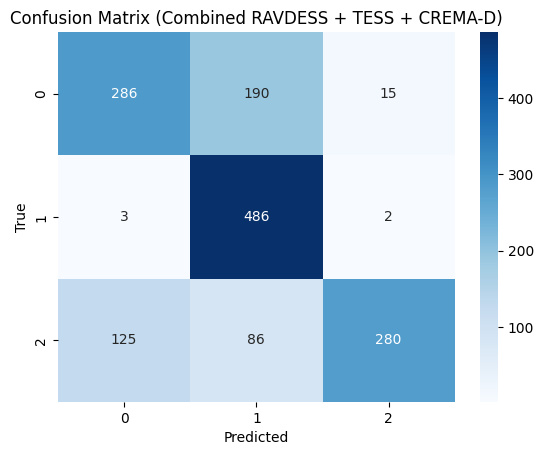

Total misclassified examples: 421


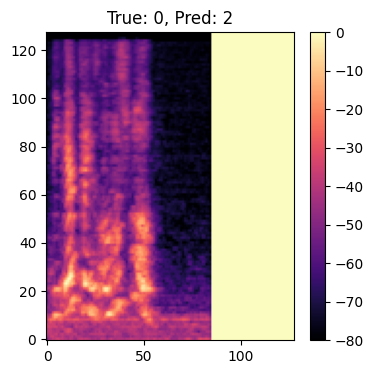

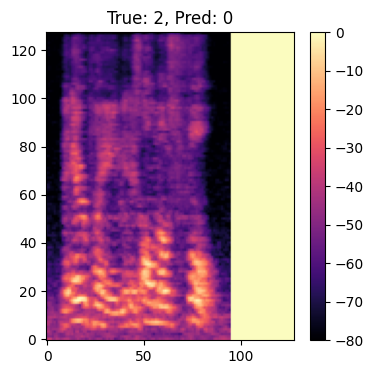

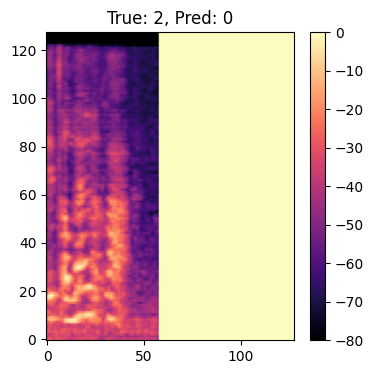

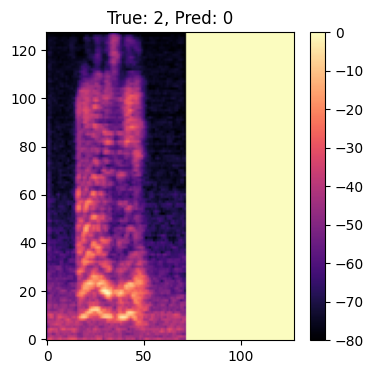

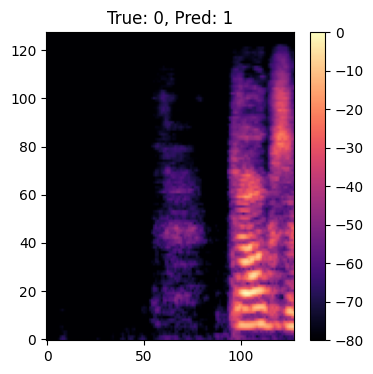

In [23]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_labels))

cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Combined RAVDESS + TESS + CREMA-D)")
plt.show()

# Identify misclassified samples
misclassified_indices = np.where(y_pred_labels != y_true)[0]

print(f"Total misclassified examples: {len(misclassified_indices)}")

# Display first few misclassified spectrograms
for i in misclassified_indices[:5]:
    plt.figure(figsize=(4, 4))
    plt.imshow(X_test[i].squeeze(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"True: {y_true[i]}, Pred: {y_pred_labels[i]}")
    plt.colorbar()
    plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()